In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from collections import defaultdict

from scipy.stats import boxcox

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

In [2]:
train_df = pd.read_excel('/kaggle/input/mh-rental-bicycle/Train.xlsx')
test_df = pd.read_excel('/kaggle/input/mh-rental-bicycle/Test.xlsx')
sub_df = pd.read_csv('/kaggle/input/mh-rental-bicycle/Submission.csv')

In [3]:
train_full_dates = pd.date_range(start='2013-01-01', end='2016-06-01', freq='60min')[:-1]

missing_dates_dict = {}
for user_type in train_df['User_type'].unique():
    train_date = train_df[train_df['User_type']==user_type]['Datetime'].tolist()
    missing_dates = [i for i in train_full_dates if i not in train_date]
    missing_dates_dict[user_type] = missing_dates
    print(f"{user_type}: {len(missing_dates)} missing dates")

occasional: 97 missing dates
subscribed: 50 missing dates


In [4]:
train_df.drop(columns='Unnamed: 0', inplace=True)

train_df_s = train_df[train_df['User_type']=='subscribed'].reset_index(drop=True)
train_df_s.sort_values('Datetime', ascending=True, inplace=True)
train_df_o = train_df[train_df['User_type']=='occasional'].reset_index(drop=True)
train_df_o.sort_values('Datetime', ascending=True, inplace=True)

print(train_df_s.shape, train_df_o.shape)

(29878, 7) (29831, 7)


In [5]:
test_df.rename(
    columns={'Unnamed: 0': 'index'},
    inplace=True
)

test_df_s = test_df[test_df['User_type']=='subscribed'].reset_index(drop=True)
test_df_s.sort_values('Datetime', ascending=True, inplace=True)
test_df_o = test_df[test_df['User_type']=='occasional'].reset_index(drop=True)
test_df_o.sort_values('Datetime', ascending=True, inplace=True)

print(test_df_s.shape, test_df_o.shape)

(720, 7) (720, 7)


In [6]:
valid_df_s = train_df_s.iloc[-720:]
train_df_s = train_df_s.iloc[:-720]
print(valid_df_s.shape, train_df_s.shape)

valid_df_o = train_df_o.iloc[-720:]
train_df_o = train_df_o.iloc[:-720]
print(valid_df_o.shape, train_df_o.shape)

(720, 7) (29158, 7)
(720, 7) (29111, 7)


In [7]:
for user_type in train_df['User_type'].unique():

    if user_type == 'occasional':
        temp_train_df = train_df_o.copy()
    else:
        temp_train_df = train_df_s.copy()

    train_dict = defaultdict(list)
    valid_dict = defaultdict(list)

    for missing_date in missing_dates_dict[user_type]:

        if missing_date < valid_df_s.iloc[0]['Datetime']:
            train_dict['Datetime'].append(missing_date)
            train_dict['St_Hour'].append(missing_date.hour)
            train_dict['St_Day'].append(missing_date.day)
            train_dict['St_Month'].append(missing_date.month)
            train_dict['St_Year'].append(missing_date.year)
#             train_dict['dayofweek'].append(missing_date.dayofweek)
#             train_dict['weekofyear'].append(missing_date.isocalendar()[1])
#             train_dict['dayofyear'].append(missing_date.dayofyear)
            train_dict['User_type'].append(user_type)
            temp_df = temp_train_df[
                (temp_train_df['Datetime']<missing_date) & 
                (temp_train_df['St_Hour']==missing_date.hour)
            ]
            train_dict['Rental_Bicycles_Count'] = temp_df['Rental_Bicycles_Count'].median()
        else:
            valid_dict['Datetime'].append(missing_date)
            valid_dict['St_Hour'].append(missing_date.hour)
            valid_dict['St_Day'].append(missing_date.day)
            valid_dict['St_Month'].append(missing_date.month)
            valid_dict['St_Year'].append(missing_date.year)
#             valid_dict['dayofweek'].append(missing_date.dayofweek)
#             valid_dict['weekofyear'].append(missing_date.isocalendar()[1])
#             valid_dict['dayofyear'].append(missing_date.dayofyear)
            valid_dict['User_type'].append(user_type)
            valid_dict['Rental_Bicycles_Count'] = temp_train_df[temp_train_df['St_Hour']==missing_date.hour]['Rental_Bicycles_Count'].median()

    if user_type == 'occasional':
        temp_train_df_o = pd.DataFrame(train_dict)
        temp_train_df_o = temp_train_df_o[train_df_o.columns]
        train_df_o = pd.concat([train_df_o, temp_train_df_o], axis=0).reset_index(drop=True)
        train_df_o.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_o = pd.DataFrame(valid_dict)
            temp_valid_df_o = temp_valid_df_o[valid_df_o.columns]
            valid_df_o = pd.concat([valid_df_o, temp_valid_df_o], axis=0).reset_index(drop=True)
            valid_df_o.sort_values('Datetime', ascending=True, inplace=True)
    else:
        temp_train_df_s = pd.DataFrame(train_dict)
        temp_train_df_s = temp_train_df_s[train_df_s.columns]
        train_df_s = pd.concat([train_df_s, temp_train_df_s], axis=0).reset_index(drop=True)
        train_df_s.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_s = pd.DataFrame(valid_dict)
            temp_valid_df_s = temp_valid_df_s[valid_df_s.columns]
            valid_df_s = pd.concat([valid_df_s, temp_valid_df_s], axis=0).reset_index(drop=True)
            valid_df_s.sort_values('Datetime', ascending=True, inplace=True)

print(valid_df_s.shape, train_df_s.shape)
print(valid_df_o.shape, train_df_o.shape)

(720, 7) (29208, 7)
(720, 7) (29208, 7)


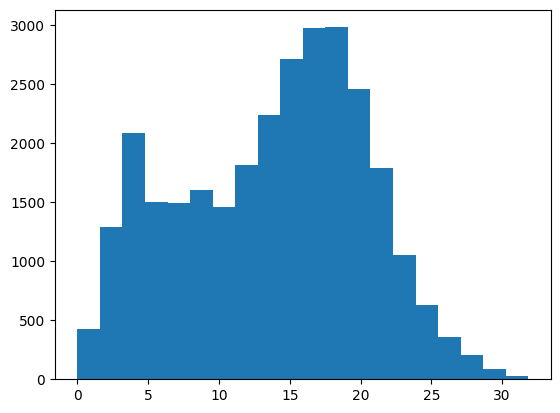

In [8]:
transformed_data_s, best_lambda_s = boxcox(train_df_s['Rental_Bicycles_Count']) 
train_df_s['Rental_Bicycles_Count'] = transformed_data_s

plt.hist(train_df_s['Rental_Bicycles_Count'], bins=20);

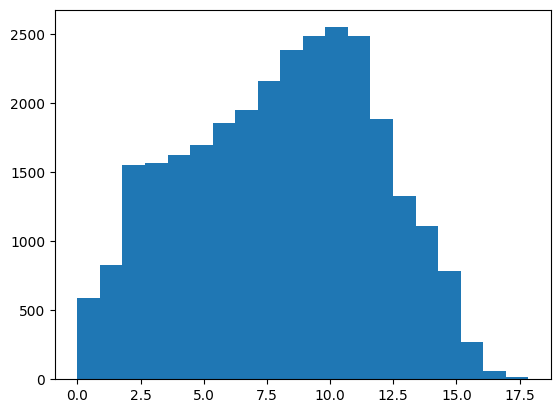

In [9]:
transformed_data_o, best_lambda_o = boxcox(train_df_o['Rental_Bicycles_Count']) 
train_df_o['Rental_Bicycles_Count'] = transformed_data_o

plt.hist(transformed_data_o, bins=20);

In [10]:
def apply_box_cox_transform(x, lamdba):
    if lamdba != 0:
        x_tf = (x**lamdba - 1) / lamdba
    else:
        x_tf = np.log(x)
        
    return x_tf

def invboxcox(x, lamdba):
    if lamdba == 0:
        reversed_x = np.exp(x)
    else:
        reversed_x = np.exp(np.log(lamdba*x+1)/lamdba)
    return reversed_x

In [11]:
valid_df_s['Rental_Bicycles_Count'] = valid_df_s['Rental_Bicycles_Count'].\
    apply(lambda x: apply_box_cox_transform(x, lamdba=best_lambda_s))

valid_df_o['Rental_Bicycles_Count'] = valid_df_o['Rental_Bicycles_Count'].\
    apply(lambda x: apply_box_cox_transform(x, lamdba=best_lambda_o))

In [12]:
scaler_s = MinMaxScaler()

train_df_s['Rental_Bicycles_Count'] = scaler_s.fit_transform(train_df_s['Rental_Bicycles_Count'].to_frame())
valid_df_s['Rental_Bicycles_Count'] = scaler_s.transform(valid_df_s['Rental_Bicycles_Count'].to_frame())

scaler_o = MinMaxScaler()

train_df_o['Rental_Bicycles_Count'] = scaler_o.fit_transform(train_df_o['Rental_Bicycles_Count'].to_frame())
valid_df_o['Rental_Bicycles_Count'] = scaler_o.transform(valid_df_o['Rental_Bicycles_Count'].to_frame())

In [13]:
train_ts_s = train_df_s['Rental_Bicycles_Count'].values.astype('float32')
train_ts_o = train_df_o['Rental_Bicycles_Count'].values.astype('float32')

valid_ts_s = valid_df_s['Rental_Bicycles_Count'].values.astype('float32')
valid_ts_o = valid_df_o['Rental_Bicycles_Count'].values.astype('float32')

print(train_ts_s.shape, train_ts_o.shape)
print(valid_ts_s.shape, valid_ts_o.shape)

(29208,) (29208,)
(720,) (720,)


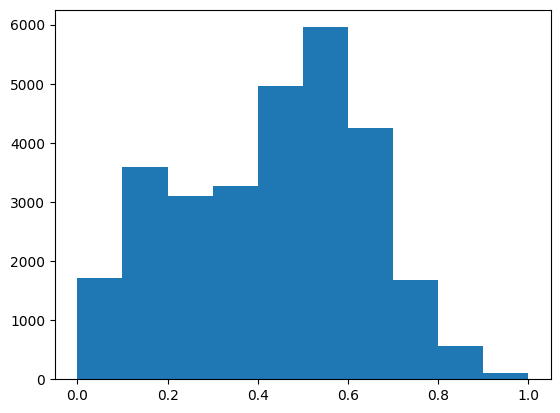

In [14]:
plt.hist(train_ts_s);

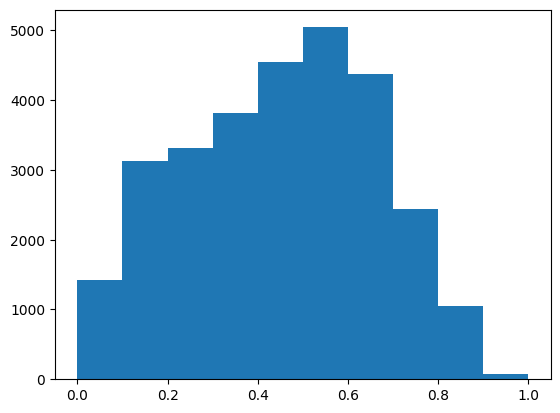

In [15]:
plt.hist(train_ts_o);

In [16]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).unsqueeze(2), torch.tensor(y).unsqueeze(2)

In [17]:
LOOKBACK = 24

X_train_s, y_train_s = create_dataset(train_ts_s, lookback=LOOKBACK)
X_valid_s, y_valid_s = create_dataset(valid_ts_s, lookback=LOOKBACK)
print(X_train_s.shape, y_train_s.shape)
print(X_valid_s.shape, y_valid_s.shape)

X_train_o, y_train_o = create_dataset(train_ts_o, lookback=LOOKBACK)
X_valid_o, y_valid_o = create_dataset(valid_ts_o, lookback=LOOKBACK)
print(X_train_o.shape, y_train_o.shape)
print(X_valid_o.shape, y_valid_o.shape)

/tmp/ipykernel_24/1171032600.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X).unsqueeze(2), torch.tensor(y).unsqueeze(2)


torch.Size([29184, 24, 1]) torch.Size([29184, 24, 1])
torch.Size([696, 24, 1]) torch.Size([696, 24, 1])
torch.Size([29184, 24, 1]) torch.Size([29184, 24, 1])
torch.Size([696, 24, 1]) torch.Size([696, 24, 1])


In [18]:
class RentalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [19]:
# train_df.drop(columns='Unnamed: 0', inplace=True)

# train_df_s = train_df[train_df['User_type']=='subscribed'].reset_index(drop=True)
# train_df_s.sort_values('Datetime', ascending=True, inplace=True)
# train_df_o = train_df[train_df['User_type']=='occasional'].reset_index(drop=True)
# train_df_o.sort_values('Datetime', ascending=True, inplace=True)

# print(train_df_s.shape, train_df_o.shape)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
model_s = RentalModel()
model_s = model_s.to(device)
optimizer = optim.Adam(model_s.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_s, y_train_s), shuffle=True, batch_size=32)
 
n_epochs = 1000

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    temp_train_losses = []
    model_s.train()
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model_s(X_batch)
        loss = loss_fn(y_pred, y_batch)
        temp_train_losses.append(np.sqrt(loss.detach().cpu().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_rmse = np.mean(temp_train_losses)
    train_losses.append(train_rmse)
    
    # Validation
    model_s.eval()
    with torch.no_grad():
#         y_pred = model_s(X_train_s.to(device)).cpu()
#         train_rmse = np.sqrt(loss_fn(y_pred, y_train_s))
        y_pred = model_s(X_valid_s.to(device)).cpu()
        valid_rmse = np.sqrt(loss_fn(y_pred, y_valid_s))
        valid_losses.append(valid_rmse)
        
    if epoch % 100 != 0:
        continue
    print("Epoch %d: train RMSE %.4f, valid RMSE %.4f" % (epoch, train_rmse, valid_rmse))

Epoch 0: train RMSE 0.1080, valid RMSE 0.0670
Epoch 100: train RMSE 0.0386, valid RMSE 0.0448
Epoch 200: train RMSE 0.0372, valid RMSE 0.0449
Epoch 300: train RMSE 0.0365, valid RMSE 0.0454
Epoch 400: train RMSE 0.0361, valid RMSE 0.0454
Epoch 500: train RMSE 0.0358, valid RMSE 0.0464
Epoch 600: train RMSE 0.0356, valid RMSE 0.0461
Epoch 700: train RMSE 0.0354, valid RMSE 0.0453
Epoch 800: train RMSE 0.0353, valid RMSE 0.0459
Epoch 900: train RMSE 0.0352, valid RMSE 0.0460


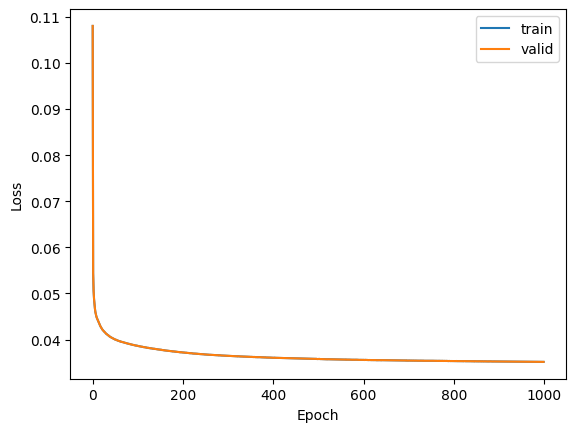

In [22]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(valid_losses)), train_losses, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

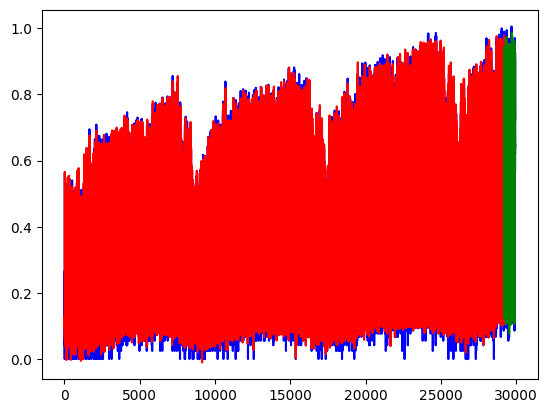

In [23]:
timeseries = pd.concat(
        [
            train_df_s[["Rental_Bicycles_Count"]],
            valid_df_s[["Rental_Bicycles_Count"]],
        ],
        axis=0
    ).values.astype('float32')

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model_s(X_train_s.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[LOOKBACK:train_df_s.shape[0]] = model_s(X_train_s.to(device)).cpu()[:, -1, :]
    # shift valid predictions for plotting
    valid_plot = np.ones_like(timeseries) * np.nan
    valid_plot[train_df_s.shape[0]+LOOKBACK:len(timeseries)] = model_s(X_valid_s.to(device)).cpu()[:, -1, :]

    for i in range(LOOKBACK):
        if i != 0:
            temp_valid = np.zeros(LOOKBACK)
            temp_valid[:LOOKBACK-i] = train_df_s.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
            temp_valid[LOOKBACK-i:] = valid_plot[train_df_s.shape[0]:train_df_s.shape[0]+i].reshape(-1,)
        else:
            temp_valid = train_df_s.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
        temp_valid = torch.as_tensor(temp_valid).view(1, -1, 1).float()
        valid_plot[train_df_s.shape[0]+i] = model_s(temp_valid.to(device)).cpu()[:, -1, :]

# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(valid_plot, c='g')
plt.show()

In [24]:
train_inv_scaler_values_s = scaler_s.inverse_transform(train_plot[LOOKBACK:len(train_plot)-720])
train_inv_bc_values_s = [invboxcox(x, lamdba=best_lambda_s)[0] for x in train_inv_scaler_values_s]
train_score = np.sqrt(
    mean_squared_error(train_df_s.iloc[LOOKBACK:]['Rental_Bicycles_Count'], train_inv_bc_values_s)
)

valid_inv_scaler_values_s = scaler_s.inverse_transform(valid_plot[train_df_s.shape[0]:])
valid_inv_bc_values_s = [invboxcox(x, lamdba=best_lambda_s)[0] for x in valid_inv_scaler_values_s]
valid_score = np.sqrt(mean_squared_error(valid_df_s['Rental_Bicycles_Count'], valid_inv_bc_values_s))

print(f"subscribed: Train RMSE: {train_score:.2f}, Validation RMSE: {valid_score:.2f}")

subscribed: Train RMSE: 348.15, Validation RMSE: 554.66


In [25]:
test_pred = np.zeros((720, 1))

for i in range(LOOKBACK):
    if i != 0:
        temp_test = np.zeros(LOOKBACK)
        temp_test[:LOOKBACK-i] = valid_df_s.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
        temp_test[LOOKBACK-i:] = test_pred[:i].reshape(-1,)
    else:
        temp_test = valid_df_s.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
    temp_test = torch.as_tensor(temp_test).view(1, -1, 1).float()
    test_pred[i] = model_s(temp_test.to(device)).detach().cpu()[:, -1, :]
    
for i in range(LOOKBACK, test_pred.shape[0]):
    temp_test = test_pred[i-LOOKBACK:i]
    temp_test = torch.as_tensor(temp_test).view(1, -1, 1).float()
    test_pred[i] = model_s(temp_test.to(device)).detach().cpu()[:, -1, :]
    
test_inv_scaler_values_s = scaler_s.inverse_transform(test_pred.reshape(-1, 1))
test_inv_bc_values_s = [invboxcox(x, lamdba=best_lambda_s)[0] for x in test_inv_scaler_values_s]

In [26]:
X_test_s = pd.DataFrame()
X_test_s['index'] = test_df_s['index']
X_test_s['Rental_Bicycles_Count'] = test_inv_bc_values_s
X_test_s.head()

,index,Rental_Bicycles_Count
0,1,325.448720
1,3,185.430819
2,5,123.401814
3,7,62.351915
4,9,28.693110


In [27]:
model_o = RentalModel()
model_o = model_o.to(device)
optimizer = optim.Adam(model_o.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_o, y_train_o), shuffle=True, batch_size=32)
 
n_epochs = 1000

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    temp_train_losses = []
    model_o.train()
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model_o(X_batch)
        loss = loss_fn(y_pred, y_batch)
        temp_train_losses.append(np.sqrt(loss.detach().cpu().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_rmse = np.mean(temp_train_losses)
    train_losses.append(train_rmse)
    
    # Validation
    model_o.eval()
    with torch.no_grad():
#         y_pred = model_o(X_train_o.to(device)).cpu()
#         train_rmse = np.sqrt(loss_fn(y_pred, y_train_o))
        y_pred = model_o(X_valid_o.to(device)).cpu()
        valid_rmse = np.sqrt(loss_fn(y_pred, y_valid_o))
        valid_losses.append(valid_rmse)
        
    if epoch % 100 != 0:
        continue
    print("Epoch %d: train RMSE %.4f, valid RMSE %.4f" % (epoch, train_rmse, valid_rmse))

Epoch 0: train RMSE 0.0891, valid RMSE 0.0620
Epoch 100: train RMSE 0.0453, valid RMSE 0.0508
Epoch 200: train RMSE 0.0438, valid RMSE 0.0526
Epoch 300: train RMSE 0.0431, valid RMSE 0.0527
Epoch 400: train RMSE 0.0428, valid RMSE 0.0531
Epoch 500: train RMSE 0.0425, valid RMSE 0.0530
Epoch 600: train RMSE 0.0423, valid RMSE 0.0536
Epoch 700: train RMSE 0.0421, valid RMSE 0.0540
Epoch 800: train RMSE 0.0420, valid RMSE 0.0534
Epoch 900: train RMSE 0.0419, valid RMSE 0.0532


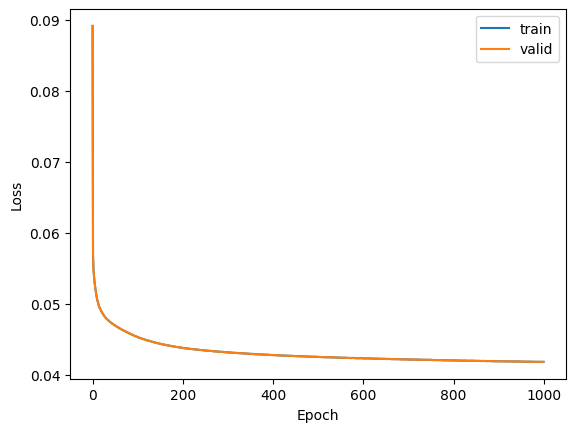

In [28]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(valid_losses)), train_losses, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

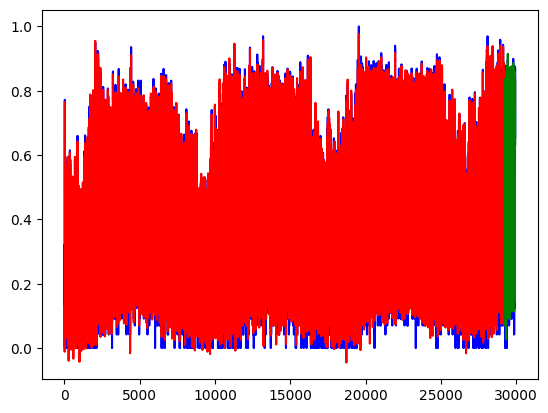

In [29]:
timeseries = pd.concat(
        [
            train_df_o[["Rental_Bicycles_Count"]],
            valid_df_o[["Rental_Bicycles_Count"]],
        ],
        axis=0
    ).values.astype('float32')

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model_o(X_train_o.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[LOOKBACK:train_df_o.shape[0]] = model_o(X_train_o.to(device)).cpu()[:, -1, :]
    # shift valid predictions for plotting
    valid_plot = np.ones_like(timeseries) * np.nan
    valid_plot[train_df_o.shape[0]+LOOKBACK:len(timeseries)] = model_o(X_valid_o.to(device)).cpu()[:, -1, :]

    for i in range(LOOKBACK):
        if i != 0:
            temp_valid = np.zeros(LOOKBACK)
            temp_valid[:LOOKBACK-i] = train_df_o.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
            temp_valid[LOOKBACK-i:] = valid_plot[train_df_o.shape[0]:train_df_o.shape[0]+i].reshape(-1,)
        else:
            temp_valid = train_df_o.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
        temp_valid = torch.as_tensor(temp_valid).view(1, -1, 1).float()
        valid_plot[train_df_o.shape[0]+i] = model_o(temp_valid.to(device)).cpu()[:, -1, :]

# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(valid_plot, c='g')
plt.show()

In [30]:
train_inv_ocaler_values_o = scaler_o.inverse_transform(train_plot[LOOKBACK:len(train_plot)-720])
train_inv_bc_values_o = [invboxcox(x, lamdba=best_lambda_o)[0] for x in train_inv_ocaler_values_o]
train_score = np.sqrt(
    mean_squared_error(train_df_o.iloc[LOOKBACK:]['Rental_Bicycles_Count'], train_inv_bc_values_o)
)

valid_inv_scaler_values_o = scaler_o.inverse_transform(valid_plot[train_df_o.shape[0]:])
valid_inv_bc_values_o = [invboxcox(x, lamdba=best_lambda_o)[0] for x in valid_inv_scaler_values_o]
valid_score = np.sqrt(mean_squared_error(valid_df_o['Rental_Bicycles_Count'], valid_inv_bc_values_o))

print(f"subscribed: Train RMSE: {train_score:.2f}, Validation RMSE: {valid_score:.2f}")

subscribed: Train RMSE: 229.05, Validation RMSE: 302.17


In [31]:
test_pred = np.zeros((720, 1))

for i in range(LOOKBACK):
    if i != 0:
        temp_test = np.zeros(LOOKBACK)
        temp_test[:LOOKBACK-i] = valid_df_o.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
        temp_test[LOOKBACK-i:] = test_pred[:i].reshape(-1,)
    else:
        temp_test = valid_df_o.iloc[-(LOOKBACK-i):]["Rental_Bicycles_Count"].values
    temp_test = torch.as_tensor(temp_test).view(1, -1, 1).float()
    test_pred[i] = model_o(temp_test.to(device)).detach().cpu()[:, -1, :]
    
for i in range(LOOKBACK, test_pred.shape[0]):
    temp_test = test_pred[i-LOOKBACK:i]
    temp_test = torch.as_tensor(temp_test).view(1, -1, 1).float()
    test_pred[i] = model_o(temp_test.to(device)).detach().cpu()[:, -1, :]
    
test_inv_scaler_values_o = scaler_o.inverse_transform(test_pred.reshape(-1, 1))
test_inv_bc_values_o = [invboxcox(x, lamdba=best_lambda_o)[0] for x in test_inv_scaler_values_o]

In [32]:
X_test_o = pd.DataFrame()
X_test_o['index'] = test_df_o['index']
X_test_o['Rental_Bicycles_Count'] = test_inv_bc_values_o
X_test_o.head()

,index,Rental_Bicycles_Count
0,0,243.696121
1,2,187.757283
2,4,148.202571
3,6,81.370361
4,8,31.040644


In [33]:
test_pred = pd.concat(
    [
        X_test_s[['index', 'Rental_Bicycles_Count']], 
        X_test_o[['index', 'Rental_Bicycles_Count']]
    ]
).sort_values('index', ascending=True).set_index('index')

sub_df['Rental_Bicycles_Count'] = test_pred['Rental_Bicycles_Count']
sub_df.to_csv('solution6_submit.csv', index=False)
sub_df.head()

,Rental_Bicycles_Count
0,243.696121
1,325.448720
2,187.757283
3,185.430819
4,148.202571


In [34]:
sub_df['Rental_Bicycles_Count'] = test_pred['Rental_Bicycles_Count'].apply(lambda x: round(x))
sub_df.to_csv('rounded_solution6_submit.csv', index=False)
sub_df.head()

,Rental_Bicycles_Count
0,244
1,325
2,188
3,185
4,148
